# Object Detection on a Custom Dataset using YOLO v5

Yolov5 is a modern, fast and pretty accurate object detection model for images and video streams. There is no secure information about the paternity of it, but we will use the open source version of the model released by Ultralytics [https://ultralytics.com/]. Starting from our self-labeled custom dataset, we are going to finetune yolov5 on it, making it learn to recognize fire and smoke from input images. In this notebook we will train a model that works on normal RGB pictures.


First of all, we check the GPU power at our disposal:

In [ ]:
!nvidia-smi

Thu May 26 16:26:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## Prerequisites

We'll install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model. Apex is a Pytorch extension with NVIDIA-maintained utilities to streamline mixed precision and distributed training, in order to speed-up computation and optimize parallelization over multiple GPUs

In [ ]:
!rm -r /content/apex
!git clone https://github.com/NVIDIA/apex
!cd apex
!pip install -v --disable-pip-version-check --no-cache-dir /content/apex

rm: cannot remove '/content/apex': No such file or directory
Cloning into 'apex'...
remote: Enumerating objects: 9746, done.
remote: Counting objects: 100% (817/817), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 9746 (delta 518), reused 596 (delta 377), pack-reused 8929
Receiving objects: 100% (9746/9746), 14.85 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (6631/6631), done.
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /

## Import the dataset

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import os
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

from pylab import rcParams
import matplotlib.pyplot as plt



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! rm -r trainingSet
! unzip -q '/content/drive/Shareddrives/SEAI Project/Dataset/normal_images/trainingSet.zip'
! mkdir /content/trainingSet/images
! mkdir /content/trainingSet/labels
! mv /content/trainingSet/*.txt /content/trainingSet/labels
! mv /content/trainingSet/*.* /content/trainingSet/images

rm: cannot remove 'trainingSet': No such file or directory


In [ ]:
NUM_CLASSES=2
classes=['Fire', 'Smoke']
IMAGE_DIR = '/content/trainingSet/images'
LABEL_DIR = '/content/trainingSet/labels'

In [ ]:
np.random.seed(42)
image_list = os.listdir(IMAGE_DIR)
image_list.sort()
train_images, val_images = train_test_split(image_list, test_size=0.20)
val_images, test_images = train_test_split(val_images, test_size=0.25)

np.random.seed(42)
label_list = os.listdir(LABEL_DIR)
label_list.sort()
train_labels, val_labels = train_test_split(label_list, test_size=0.20)
val_labels, test_labels = train_test_split(val_labels, test_size=0.25)

In [ ]:
print(train_images[0], train_images[1001], train_images[-1])
print(train_labels[0], train_labels[1001], train_labels[-1])
print()
print(val_images[0], val_images[40], val_images[-1])
print(val_labels[0], val_labels[40], val_labels[-1])
print()
print(test_images[0], test_images[10], test_images[-1])
print(test_labels[0], test_labels[10], test_labels[-1])
print()
print(len(train_images), len(val_images), len(test_images))
print(len(train_labels), len(val_labels), len(test_labels))

fire.623.png 12074.jpg ph00225.jpg
fire.623.txt 12074.txt ph00225.txt

95 (2).jpg ph00288.jpg 15274.jpg
95 (2).txt ph00288.txt 15274.txt

11140.jpg 117.jpg 20913.jpg
11140.txt 117.txt 20913.txt

3168 594 198
3168 594 198


### Sample image and annotation

Let's have a look at an image from the dataset.

In [ ]:
img_path = train_images[10]
label_path = train_labels[10]

img = Image.open(os.path.join(IMAGE_DIR, img_path)).convert('RGB')
with (open(os.path.join(LABEL_DIR, label_path), "r")) as f:
  label = f.readlines()

print(label)
img

In [ ]:
from torchvision.transforms.transforms import Compose
from torchvision.transforms import ToTensor, PILToTensor, Compose

def img_to_tensor(img):
  transform = Compose([PILToTensor()])
  tensor = transform(img)
  return tensor

img_to_tensor(img).shape

In [ ]:
import cv2
import matplotlib.pyplot as plt

def draw_img_with_bounding_boxes(img, tensor, label): 
  img = np.array(img)
  _, dh, dw = tensor.shape
  for row in label:

    # Split string to float
    class_type, x, y, w, h = map(float, row.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    if class_type == 0: #Fire
      cv2.rectangle(img, (l, t), (r, b), (255, 0, 0), 1)
    else:
      cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

  plt.imshow(img)

draw_img_with_bounding_boxes(img, img_to_tensor(img), label)

## Create directories for learning sets

In [ ]:
import shutil

! mkdir /content/trainingSet/images/training
! mkdir /content/trainingSet/labels/training
! mkdir /content/trainingSet/images/validation
! mkdir /content/trainingSet/labels/validation
! mkdir /content/trainingSet/images/test
! mkdir /content/trainingSet/labels/test

TRAIN_IMG_DIR = '/content/trainingSet/images/training'
TRAIN_LABELS_DIR = '/content/trainingSet/labels/training'
VAL_IMG_DIR = '/content/trainingSet/images/validation'
VAL_LABELS_DIR = '/content/trainingSet/labels/validation'
TEST_IMG_DIR = '/content/trainingSet/images/test'
TEST_LABELS_DIR = '/content/trainingSet/labels/test'

for (img, label) in zip(train_images, train_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(TRAIN_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(TRAIN_LABELS_DIR, label))

for (img, label) in zip(val_images, val_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(VAL_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(VAL_LABELS_DIR, label))

for (img, label) in zip(test_images, test_labels):
  shutil.move(os.path.join(IMAGE_DIR, img), os.path.join(TEST_IMG_DIR, img))
  shutil.move(os.path.join(LABEL_DIR, label), os.path.join(TEST_LABELS_DIR, label))

print(len(os.listdir(TRAIN_IMG_DIR)), len(os.listdir(VAL_IMG_DIR)), len(os.listdir(TEST_IMG_DIR)))
print(len(os.listdir(TRAIN_LABELS_DIR)), len(os.listdir(VAL_LABELS_DIR)), len(os.listdir(TEST_LABELS_DIR)))

3168 594 198
3168 594 198


In [ ]:
!tree trainingSet -L 2

trainingSet
├── images
│   ├── test
│   ├── training
│   └── validation
└── labels
    ├── test
    ├── training
    └── validation

8 directories, 0 files


In [ ]:
!cat /content/trainingSet/labels/training/00000.txt

0 0.510591 0.453398 0.107023 0.196117
1 0.607581 0.209709 0.211817 0.407767


## Fine-tuning YOLO v5


### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away


In [ ]:
!rm -r yolov5
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
!git clone https://github.com/ultralytics/yolov5

rm: cannot remove 'yolov5': No such file or directory
     |████████████████████████████████| 596 kB 5.0 MB/s 
Cloning into 'yolov5'...
remote: Enumerating objects: 13673, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 13673 (delta 6), reused 0 (delta 0), pack-reused 13661
Receiving objects: 100% (13673/13673), 12.20 MiB | 32.36 MiB/s, done.
Resolving deltas: 100% (9548/9548), done.


In [ ]:
!pip install -r /content/yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
with(open('/content/yolov5/data/fire.yaml', "w")) as f:
  f.writelines(["train: /content/trainingSet/images/training/\n",
  "val: /content/trainingSet/images/validation/\n",
  "test: /content/trainingSet/images/test/\n",
  "\n",
  "nc: 2\n",
  "\n",
  "names: ['Fire', 'Smoke']"
  ])

## Yolov5l

In [ ]:
with(open('/content/yolov5/models/yolov5l.yaml', "r")) as f:
   c = f.readlines()
   c[3] = "nc: 2\n"

with(open('/content/yolov5/models/yolov5l.yaml', "w")) as f:
   f.writelines(c)


### Training

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass some of parameters:

- img 254 - size of the images: 254x254
- batch 64 - 64 images per batch
- epochs 30 - train for 30 epochs
- data ./data/clothing.yaml - path to dataset config
- cfg ./models/yolov5l.yaml - model config
- weights yolov5l.pt - use pre-trained weights from the YOLOv5l model
- name yolov5l_clothing - name of our model
- cache - cache dataset images for faster training


In [ ]:
!python /content/yolov5/train.py --img 254 --batch 64 --epochs 30 \
  --data /content/yolov5/data/fire.yaml --cfg /content/yolov5/models/yolov5l.yaml --weights yolov5l.pt \
  --name yolov5l_fire_norm_images --cache

train: weights=yolov5l.pt, cfg=/content/yolov5/models/yolov5l.yaml, data=/content/yolov5/data/fire.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=64, imgsz=254, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5l_fire_norm_images, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw

### Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

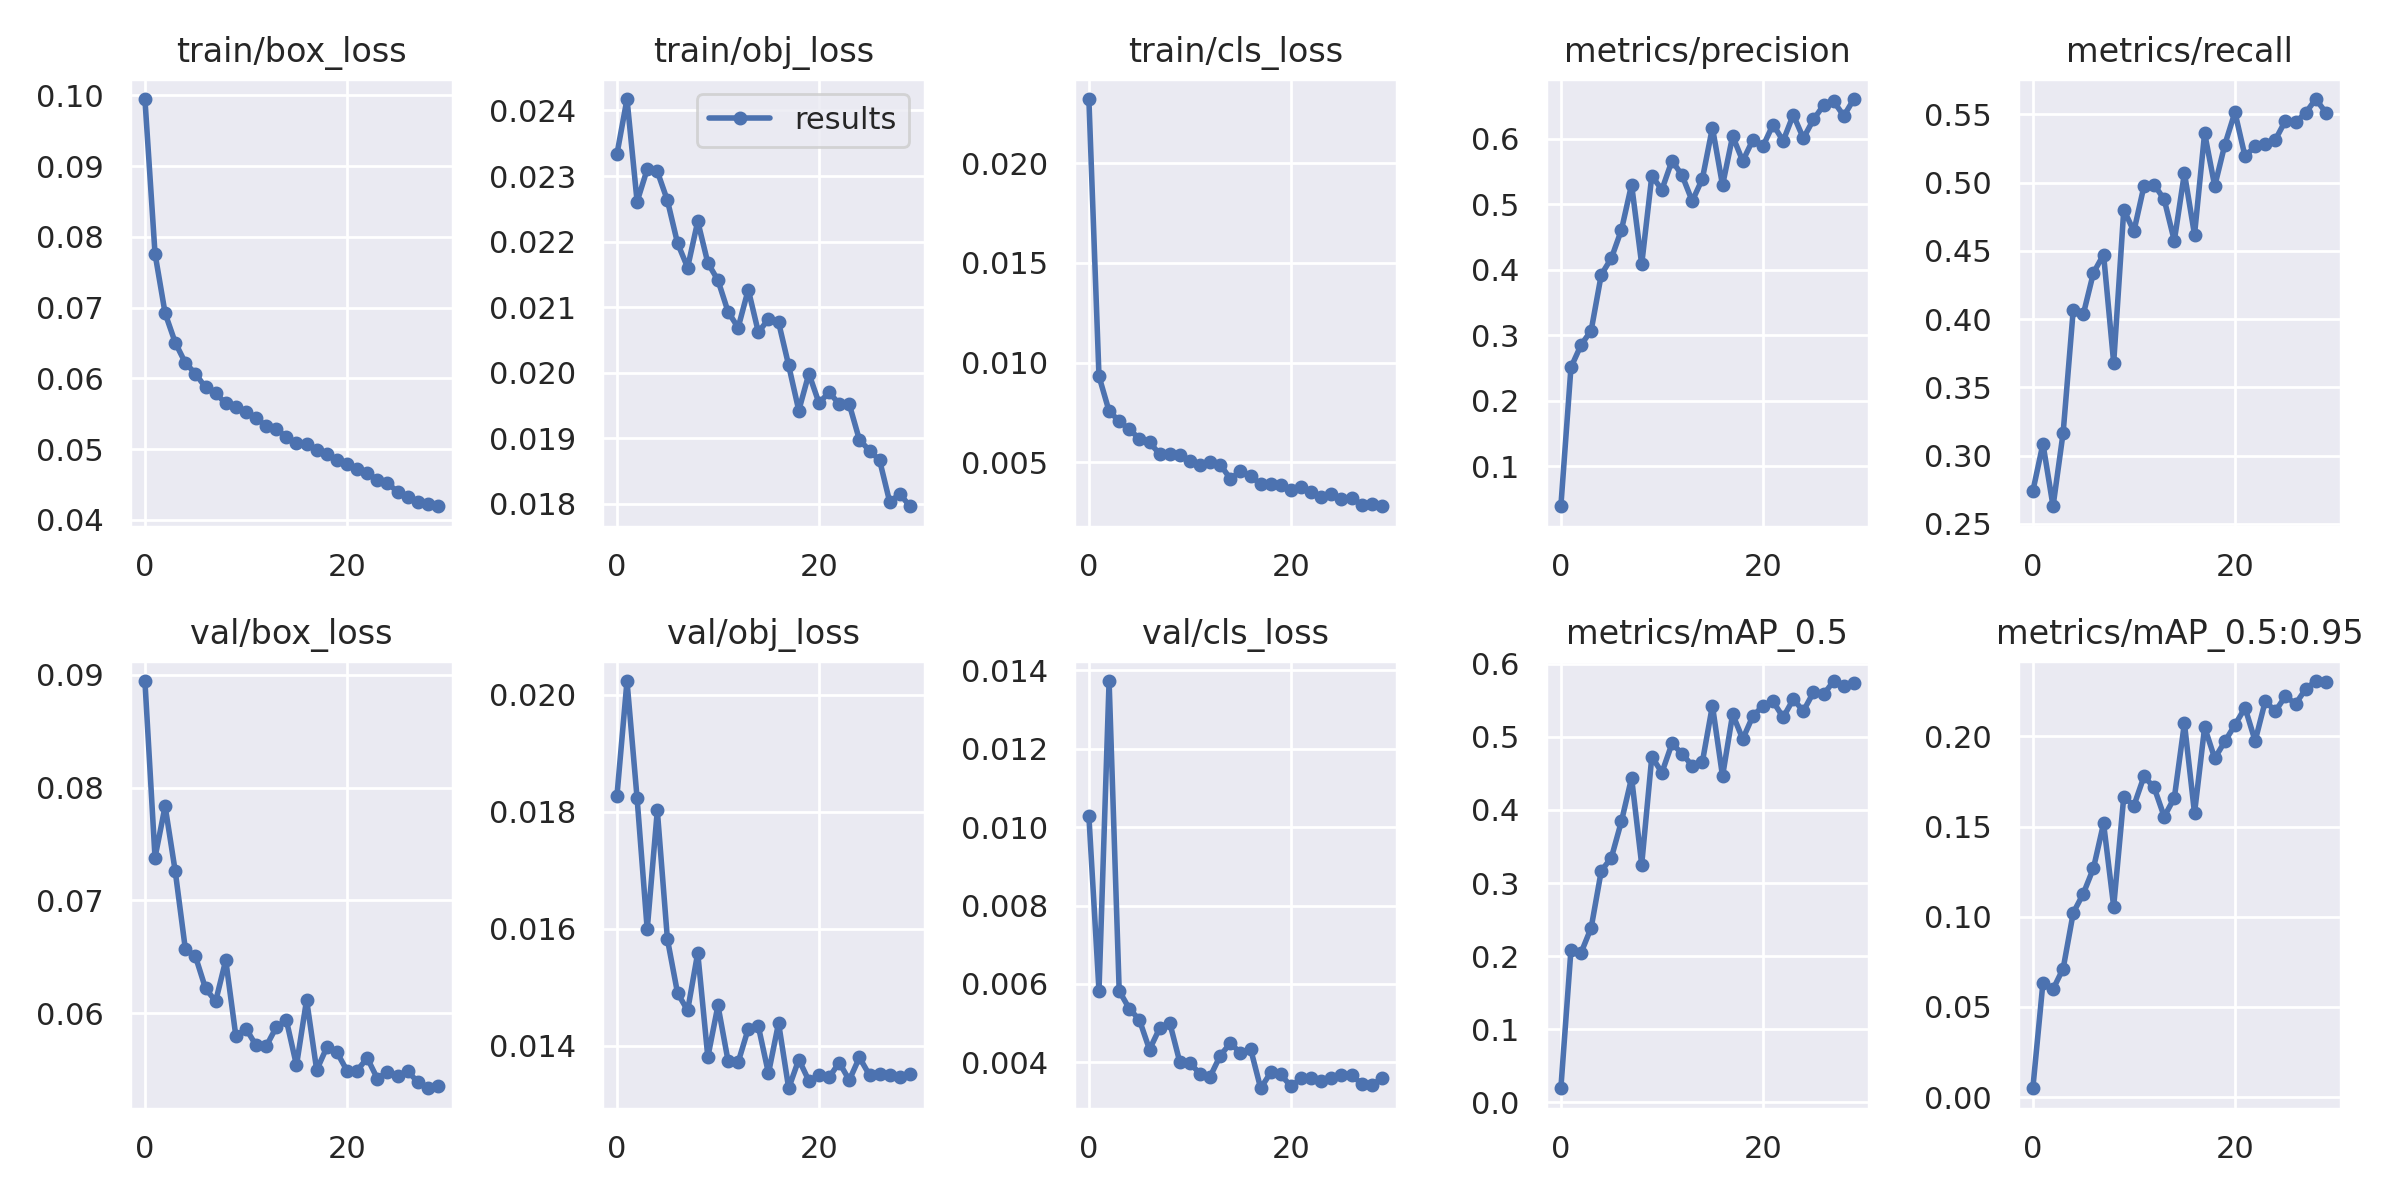

In [ ]:
results = '/content/yolov5/runs/train/yolov5l_fire_norm_images/results.png'
results_png = Image.open(results)
results_png

In [ ]:
!python /content/yolov5/val.py --data /content/yolov5/data/fire.yaml --weights /content/yolov5/runs/train/yolov5l_fire_norm_images/weights/best.pt --img 254 --task test

val: data=/content/yolov5/data/fire.yaml, weights=['/content/yolov5/runs/train/yolov5l_fire_norm_images/weights/best.pt'], batch_size=32, imgsz=254, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46113663 parameters, 0 gradients, 107.8 GFLOPs
test: Scanning '/content/trainingSet/labels/test.cache' images and labels... 198 found, 0 missing, 69 empty, 0 corrupt: 100% 198/198 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/7 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
               Class     Images     Labels       

### Making predictions

In [ ]:
!cp /content/trainingSet/images/test/* "/content/yolov5/data/images"

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/yolov5l_fire_norm_images/weights/best.pt \
  --img 254 --conf 0.3 --source /content/yolov5/data/images

detect: weights=['/content/yolov5/runs/train/yolov5l_fire_norm_images/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[254, 254], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46113663 parameters, 0 gradients, 107.8 GFLOPs
image 1/200 /content/yolov5/data/images/00174 (2).jpg: 256x256 Done. (0.020s)
image 2/200 /content/yolov5/data/images/00464 (2).jpg: 256x256 Done. (0.020s)
image 3/200 /content/yolov5/data/images/00464.jpg: 256x256 1 Fire, 1 Smoke, Done. (0.020s)
image 4/200 /content/yolov5/data/images/00638.jpg: 

We'll write a helper function to show the results:

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (254, 254), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = np.array([load_image(img) for img in image_paths])
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=4)
  plt.figure(figsize=(200, 30))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

In [ ]:
import random 

img_paths = list(Path("/content/yolov5/runs/detect/exp").glob("*.jpg"))
random.shuffle(img_paths)

show_grid(img_paths[:16])

Output hidden; open in https://colab.research.google.com to view.

### Save resulting model

In [ ]:
! cp '/content/drive/Shareddrives/SEAI Project/Notebooks/Yolov5/real_time_detect.py' /content/yolov5/

In [ ]:
!zip -r '/content/drive/Shareddrives/SEAI Project/Models/Yolov5/yolov5l_norm_images.zip'  yolov5

updating: yolov5/ (stored 0%)
updating: yolov5/.github/ (stored 0%)
updating: yolov5/.github/workflows/ (stored 0%)
updating: yolov5/.github/workflows/ci-testing.yml (deflated 60%)
updating: yolov5/.github/workflows/docker.yml (deflated 66%)
updating: yolov5/.github/workflows/codeql-analysis.yml (deflated 52%)
updating: yolov5/.github/workflows/stale.yml (deflated 58%)
updating: yolov5/.github/workflows/greetings.yml (deflated 62%)
updating: yolov5/.github/workflows/rebase.yml (deflated 45%)
updating: yolov5/.github/CODE_OF_CONDUCT.md (deflated 60%)
updating: yolov5/.github/ISSUE_TEMPLATE/ (stored 0%)
updating: yolov5/.github/ISSUE_TEMPLATE/feature-request.yml (deflated 61%)
updating: yolov5/.github/ISSUE_TEMPLATE/config.yml (deflated 36%)
updating: yolov5/.github/ISSUE_TEMPLATE/question.yml (deflated 57%)
updating: yolov5/.github/ISSUE_TEMPLATE/bug-report.yml (deflated 59%)
updating: yolov5/.github/PULL_REQUEST_TEMPLATE.md (deflated 40%)
updating: yolov5/.github/dependabot.yml (deflat

## YOLOv5m

In [ ]:
with(open('/content/yolov5/models/yolov5m.yaml', "r")) as f:
   c = f.readlines()
   c[3] = "nc: 2\n"

with(open('/content/yolov5/models/yolov5m.yaml', "w")) as f:
   f.writelines(c)


### Training

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass some of parameters:

- img 254 - size of the images: 254x254
- batch 64 - 64 images per batch
- epochs 30 - train for 30 epochs
- data ./data/clothing.yaml - path to dataset config
- cfg ./models/yolov5l.yaml - model config
- weights yolov5l.pt - use pre-trained weights from the YOLOv5l model
- name yolov5l_clothing - name of our model
- cache - cache dataset images for faster training


In [ ]:
!python /content/yolov5/train.py --img 254 --batch 64 --epochs 50 \
  --data /content/yolov5/data/fire.yaml --cfg /content/yolov5/models/yolov5m.yaml --weights yolov5m.pt \
  --name yolov5m_fire_norm_images --cache

train: weights=yolov5m.pt, cfg=/content/yolov5/models/yolov5m.yaml, data=/content/yolov5/data/fire.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=254, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=yolov5m_fire_norm_images_2, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_

### Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

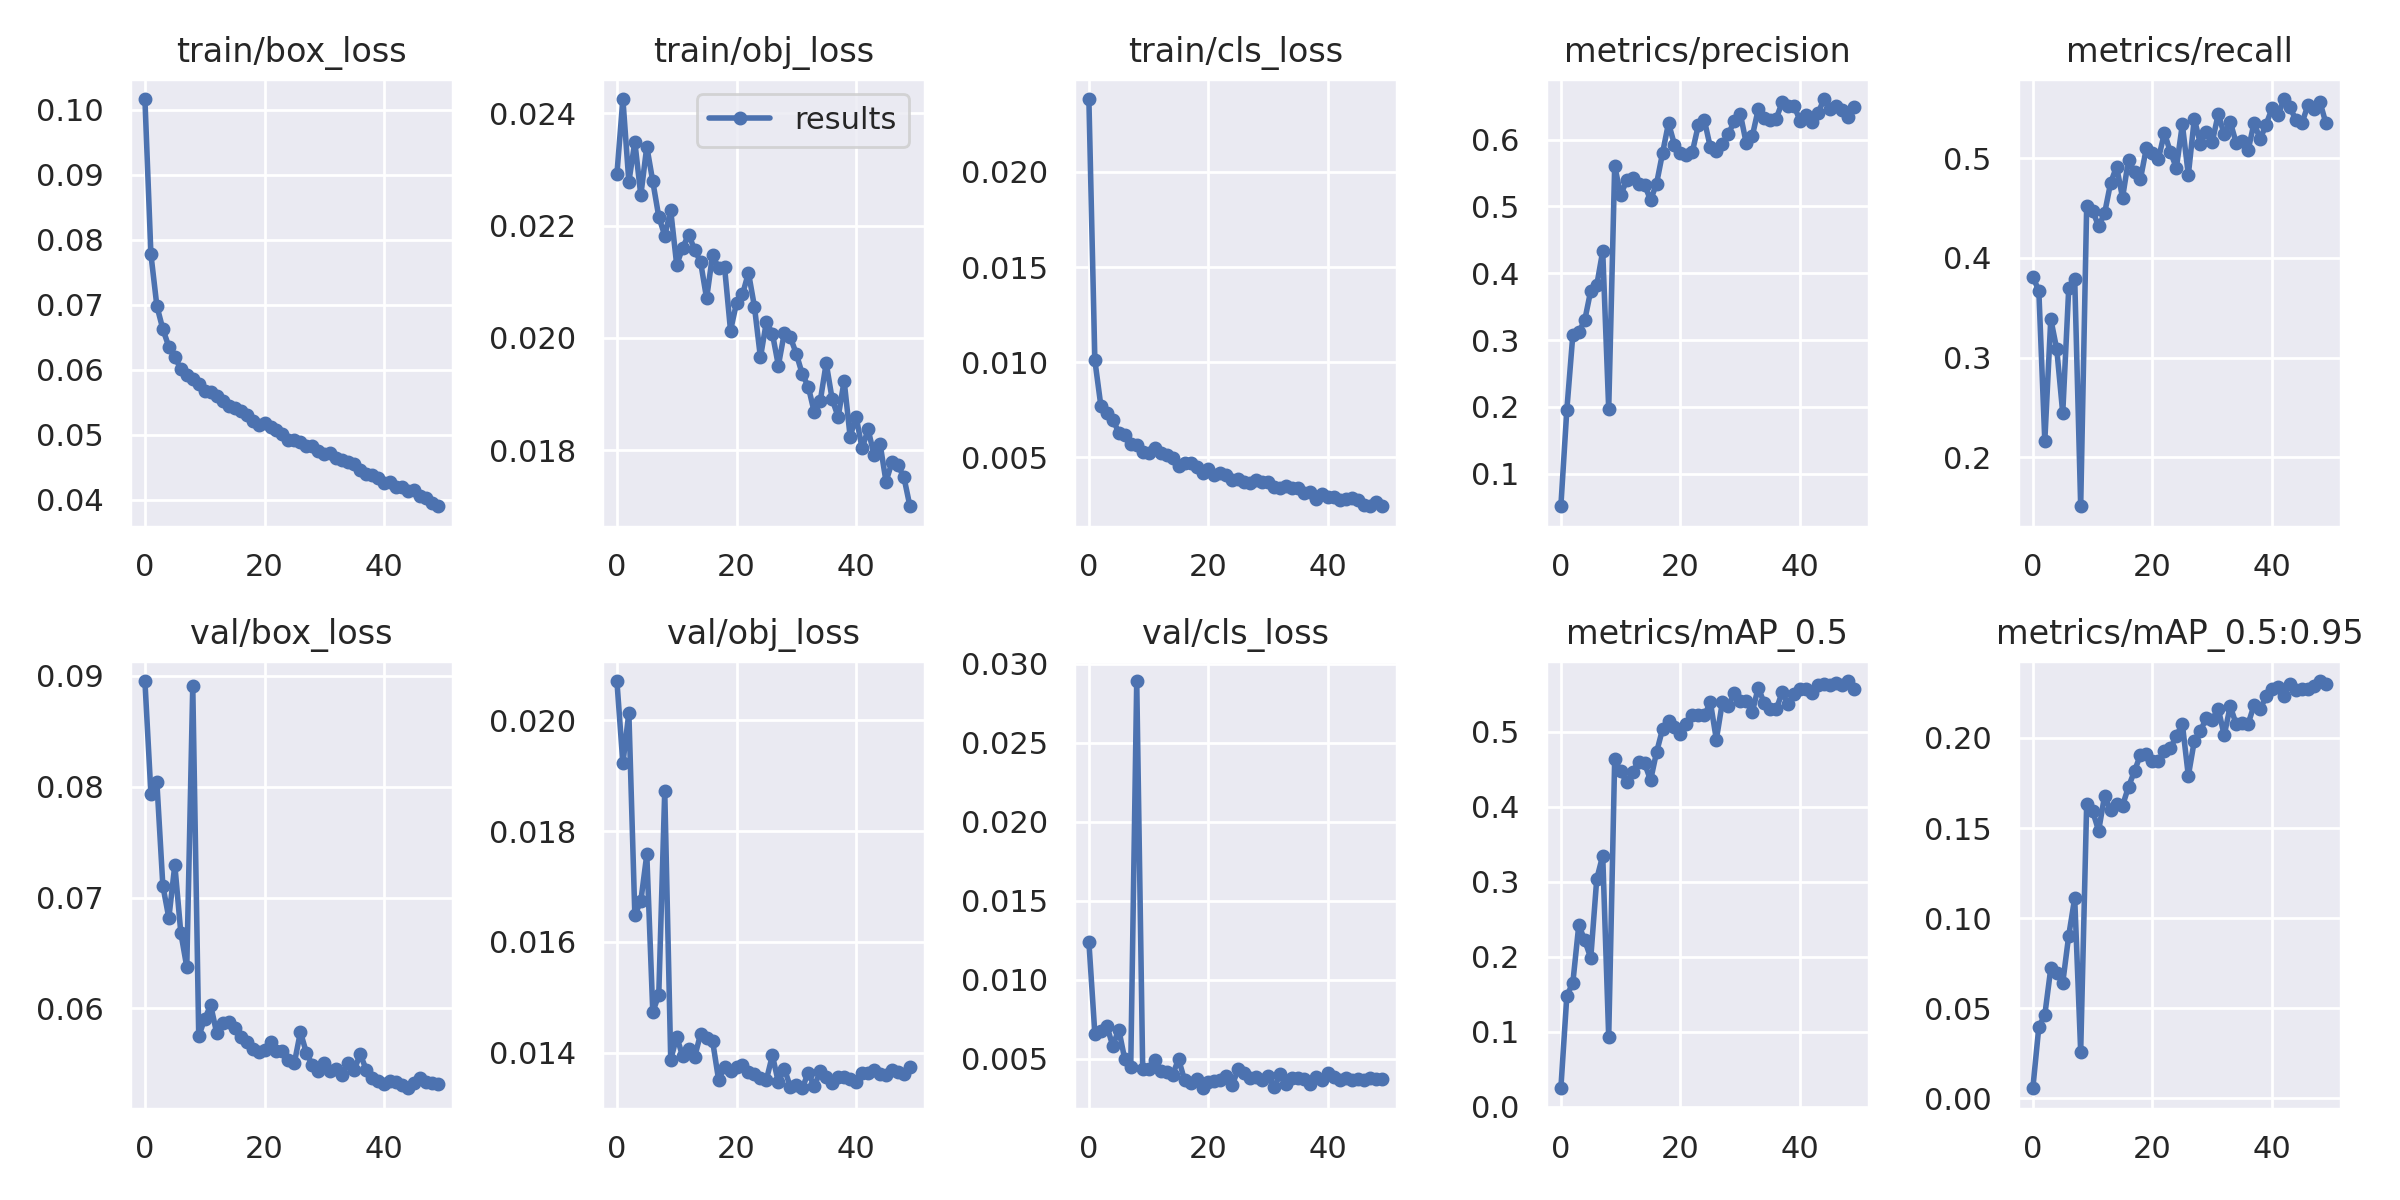

In [ ]:
results = '/content/yolov5/runs/train/yolov5m_fire_norm_images/results.png'
results_png = Image.open(results)
results_png

In [ ]:
!python /content/yolov5/val.py --data /content/yolov5/data/fire.yaml --weights /content/yolov5/runs/train/yolov5m_fire_norm_images/weights/best.pt --img 254 --task test

val: data=/content/yolov5/data/fire.yaml, weights=['/content/yolov5/runs/train/yolov5m_fire_norm_images_2/weights/best.pt'], batch_size=32, imgsz=254, conf_thres=0.001, iou_thres=0.6, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20856975 parameters, 0 gradients, 48.0 GFLOPs
test: Scanning '/content/trainingSet/labels/test' images and labels...198 found, 0 missing, 69 empty, 0 corrupt: 100% 198/198 [00:00<00:00, 369.91it/s]
test: New cache created: /content/trainingSet/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95:   0% 0/7 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incor

### Making predictions

In [ ]:
!cp /content/trainingSet/images/test/* "/content/yolov5/data/images"

In [ ]:
!python /content/yolov5/detect.py --weights /content/yolov5/runs/train/yolov5m_fire_norm_images/weights/best.pt \
  --img 254 --conf 0.3 --source /content/yolov5/data/images

detect: weights=['/content/yolov5/runs/train/yolov5m_fire_norm_images/weights/best.pt'], source=/content/yolov5/data/images, data=yolov5/data/coco128.yaml, imgsz=[254, 254], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-214-g541a5b7 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20856975 parameters, 0 gradients, 48.0 GFLOPs
image 1/200 /content/yolov5/data/images/00174 (2).jpg: 256x256 Done. (0.012s)
image 2/200 /content/yolov5/data/images/00464 (2).jpg: 256x256 Done. (0.012s)
image 3/200 /content/yolov5/data/images/00464.jpg: 256x256 1 Fire, 1 Smoke, Done. (0.012s)
image 4/200 /content/yolov5/data/images/00638.jpg: 2

We'll write a helper function to show the results:

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (254, 254), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = np.array([load_image(img) for img in image_paths])
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=4)
  plt.figure(figsize=(200, 30))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

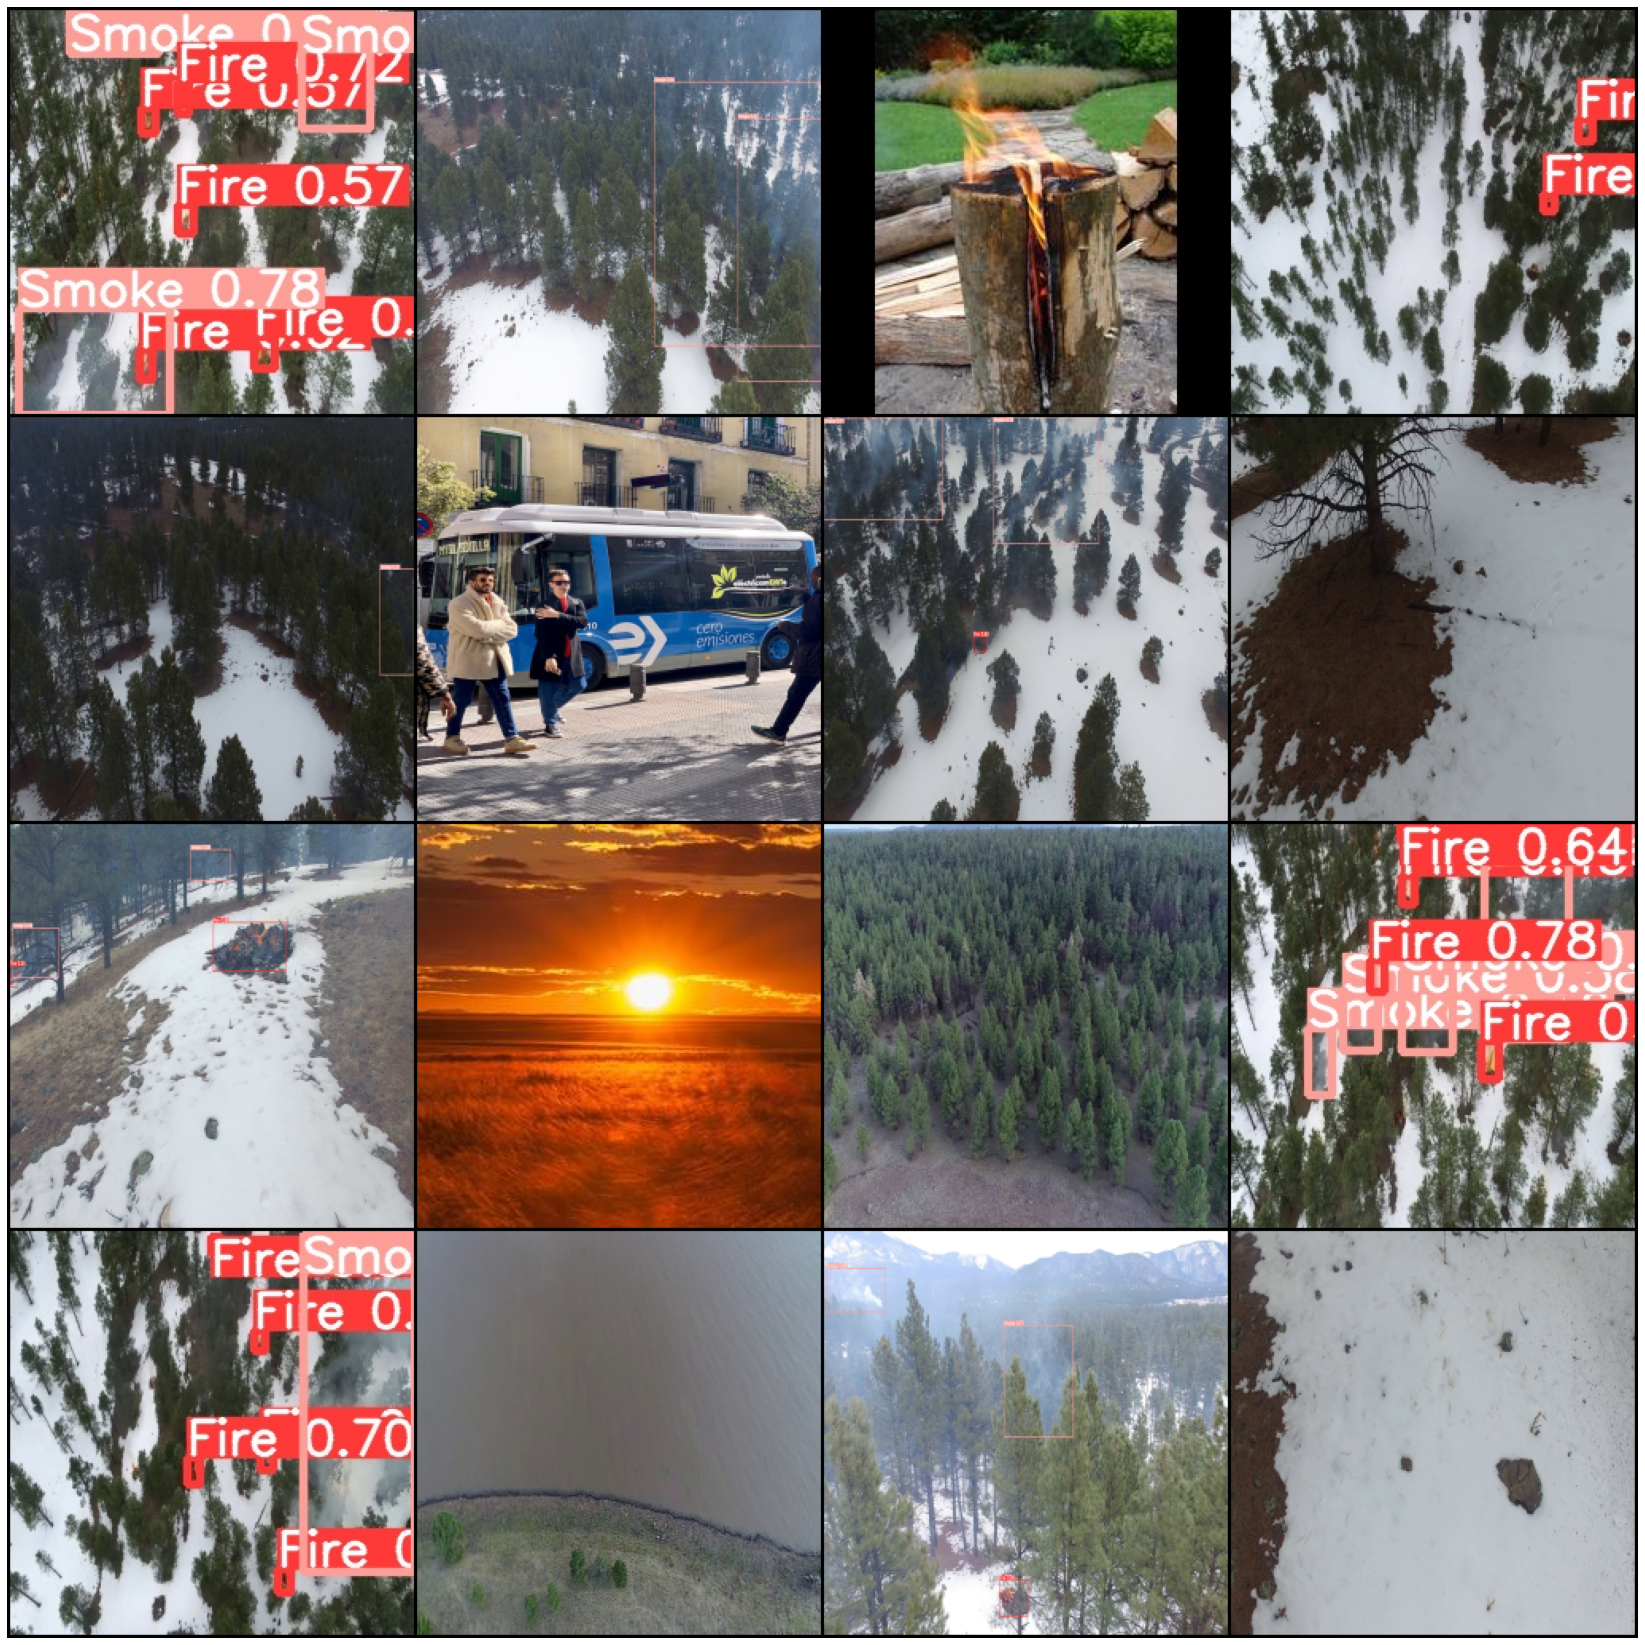

In [ ]:
img_paths = list(Path("/content/yolov5/runs/detect/exp").glob("*.jpg"))[:16]
show_grid(img_paths)

### Save resulting model

In [ ]:
! cp '/content/drive/Shareddrives/SEAI Project/Notebooks/Yolov5/real_time_detect.py' /content/yolov5/

In [ ]:
!zip -r '/content/drive/Shareddrives/SEAI Project/Models/Yolov5/yolov5m_norm_images.zip'  /content/yolov5

updating: content/yolov5/ (stored 0%)
updating: content/yolov5/README.md (deflated 72%)
updating: content/yolov5/CONTRIBUTING.md (deflated 56%)
updating: content/yolov5/.pre-commit-config.yaml (deflated 61%)
updating: content/yolov5/data/ (stored 0%)
updating: content/yolov5/data/Argoverse.yaml (deflated 56%)
updating: content/yolov5/data/coco.yaml (deflated 52%)
updating: content/yolov5/data/images/ (stored 0%)
updating: content/yolov5/data/images/02500.jpg (deflated 1%)
updating: content/yolov5/data/images/fire.690.png (deflated 0%)
updating: content/yolov5/data/images/01340.jpg (deflated 0%)
updating: content/yolov5/data/images/04582.jpg (deflated 0%)
updating: content/yolov5/data/images/00174 (2).jpg (deflated 1%)
updating: content/yolov5/data/images/04234.jpg (deflated 1%)
updating: content/yolov5/data/images/194.jpg (deflated 1%)
updating: content/yolov5/data/images/02523.jpg (deflated 1%)
updating: content/yolov5/data/images/fire.622.png (deflated 0%)
updating: content/yolov5/da

## References

- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)